In [2]:
import tensorflow as tf
from tensorflow.keras import models, datasets, layers, losses, Sequential
import tensorflow.keras.backend as K

import numpy as np
import sklearn as sk

import matplotlib.pyplot as plt

from IPython.display import display, Math, Latex

import joblib
import os
import random
import math
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000,) (60000, 28, 28, 1) (60000,)


In [3]:
def get_complex_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.summary()
    return model

def get_simple_model():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(img_rows, img_cols, channels)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.summary()
    return model

In [4]:
def train_model(model, x_train, y_train, x_test, y_test, epochs=10):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    model.fit(x_train, y_train, epochs=epochs, 
              validation_data=(x_test, y_test), use_multiprocessing=True)

In [ ]:
model = get_complex_model()
train_model(model, x_train, y_train, x_test, y_test)

In [5]:
# The FGSM method
def create_adversarial_pattern_FGSM(model, input_image, input_label):
    u = tf.Variable(input_image)
    with tf.GradientTape() as tape:
        tape.watch(u)
        prediction = model(u) # you have to change from model.predict(...) to
                                        # just calling the object in tape??? wtf
        # the input label is form [prediction] but it it in shape (1,10) :(
        # loss = tf.keras.losses.CategoricalCrossentropy()(true_labels, prediction)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(input_label, prediction)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, u)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [6]:
# Let's set up a whole prediction for the entire set of images to get accuracy changes
epsilons = [0, 0.01, 0.1, 0.2, 0.3]

def evaluate_epsilons(model, images, labels, preturbations, epsilons=[0, 0.01, 0.1, 0.2, 0.3]):
    # start evaluating model on different epsilons to discover relationship between eps and 
    # the accuracy of the model. It should go down as expected.
    lossess = []
    accuracies = []
    p_copy = images.copy()

    for i, eps in enumerate(epsilons):
        adv_xs = []
        display(Math('\epsilon = %1.2f' % eps))
        for index in range(len(preturbations)):
            p_copy[index] = tf.clip_by_value(p_copy[index] + eps * preturbations[index], -1, 1)
        loss, accuracy = model.evaluate(p_copy,  labels, verbose=1)
        lossess.append(loss)
        accuracies.append(accuracy)
        p_copy = images.copy()
    return accuracies, lossess

def get_preturbation_images(model, x_images, y_labels):
    images = tf.cast(x_images, tf.float32)
    preturbs = create_adversarial_pattern_FGSM(model, images, y_labels)
    return preturbs

In [133]:
# Let's set up a whole prediction for the entire set of images to get accuracy changes
epsilons = [0, 0.01, 0.1, 0.2, 0.3]

def evaluate_epsilons(model, images, labels, preturbations, epsilons=[0, 0.01, 0.1, 0.2, 0.3]):
    # start evaluating model on different epsilons to discover relationship between eps and 
    # the accuracy of the model. It should go down as expected.
    lossess = []
    accuracies = []
    p_copy = images.copy()

    for i, eps in enumerate(epsilons):
        adv_xs = []
        display(Math('\epsilon = %1.2f' % eps))
        for index in range(len(preturbations)):
            p_copy[index] = tf.clip_by_value(p_copy[index] + eps * preturbations[index], -1, 1)
        loss, accuracy = model.evaluate(p_copy,  labels, verbose=1)
        lossess.append(loss)
        accuracies.append(accuracy)
        p_copy = images.copy()
    return accuracies, lossess

def get_preturbation_images(model, x_images, y_labels):
    images = tf.cast(x_images, tf.float32)
    preturbs = create_adversarial_pattern_FGSM(model, images, y_labels)
    return preturbs

In [134]:
# The FGSM method
def create_adversarial_pattern_FGSM(model, input_image, input_label):
    u = tf.Variable(input_image)
    with tf.GradientTape() as tape:
        tape.watch(u)
        prediction = model(u) # you have to change from model.predict(...) to
                                        # just calling the object in tape??? wtf
        # the input label is form [prediction] but it it in shape (1,10) :(
        # loss = tf.keras.losses.CategoricalCrossentropy()(true_labels, prediction)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(input_label, prediction)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, u)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    # print(signed_grad)
    return signed_grad

In [146]:
def run_neuron_tests(model_name, num_trials=1, epsilons=[0, 0.01, 0.02, 0.04, 0.05, 0.1], 
                               ss=[0, 0.01, 0.1, 1, 10]): 
    accuracies = {}
    model = tf.keras.models.load_model(model_name)
    orig_weights = model.get_weights()
    for trial in range(num_trials):
        trial_message = 'Starting trial %i' % trial
        print(trial_message, trial)
        for ep in epsilons:
            if ep not in accuracies:
                accuracies[ep] = {}
            for s in ss:
                if s not in accuracies[ep]:
                    accuracies[ep][s] = []
                model = tf.keras.models.load_model(model_name)
                model.compile(
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
                )
                new_weight = guassian_conv_neuron(model, 4, [0, 0, 0], s)
                old_weights = model.get_weights()
                old_weights[4] = new_weight
                model.set_weights(old_weights)
                preturbs = get_preturbation_images(model, x_test, y_test)
                accuracy, _ = evaluate_epsilons(model, x_test, y_test, preturbs, epsilons=[ep])
                accuracies[ep][s].append(accuracy[0])
    return accuracies

In [7]:
def deactivate_conv_neuron(model, layer, fill_layers):
    lay = model.get_weights()[layer]
    lay[fill_layers[0]][fill_layers[1]][fill_layers[2]] = lay[fill_layers[0]][fill_layers[1]][fill_layers[2]].fill(0)
    return lay

In [43]:
model.save('com_errors')

INFO:tensorflow:Assets written to: com_errors/assets


In [97]:
model = models.load_model('com_errors')

In [ ]:
model.

In [90]:
new_weight = deactivate_conv_neuron(model, 1, [0, 1, 0])
old_weights = model.get_weights()

old_weights[2] = new_weight
model.set_weights(old_weights)

IndexError: invalid index to scalar variable.

In [73]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
accuracy

313/313 [==============================] - 1s 4ms/step - loss: nan - sparse_categorical_accuracy: 0.0924


0.09799999743700027

In [52]:
def guassian_conv_neuron(model, layer, fill_layers, s):
    lay = model.get_weights()[layer]
    test = np.copy(lay)
    layer = lay[fill_layers[0]][fill_layers[1]][fill_layers[2]]
    noise = np.random.normal(0, s, layer.shape)
    layer += noise
    return lay

In [125]:
model = models.load_model('com_errors')
new_weight = guassian_conv_neuron(model, 4, [0, 0, 0], 9)
old_weights = model.get_weights()

old_weights[4] = new_weight
model.set_weights(old_weights)

In [126]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
accuracy

313/313 [==============================] - 1s 4ms/step - loss: 0.0939 - sparse_categorical_accuracy: 0.9816


0.9868999719619751

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [131]:
ss = [0, 0.01, 0.1, 0.2, 1, 2, 10, 20, 30, 40]
accuracies = []

for i in ss:
    model = models.load_model('com_errors')
    new_weight = guassian_conv_neuron(model, 4, [0, 0, 0], i)
    old_weights = model.get_weights()

    old_weights[4] = new_weight
    model.set_weights(old_weights)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    accuracies.append(accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 9.4844 - sparse_categorical_accuracy: 0.7463


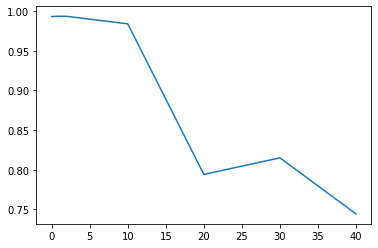

In [132]:
plt.plot(ss, accuracies)

In [147]:
accuracies = run_neuron_tests('com_errors')

Starting trial 0 0


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 0.0435 - sparse_categorical_accuracy: 0.9907


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9907


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.0435 - sparse_categorical_accuracy: 0.9911


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.0448 - sparse_categorical_accuracy: 0.9897


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.0784 - sparse_categorical_accuracy: 0.9860


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.0814 - sparse_categorical_accuracy: 0.9811


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.0814 - sparse_categorical_accuracy: 0.9811


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.0816 - sparse_categorical_accuracy: 0.9811


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.0826 - sparse_categorical_accuracy: 0.9813


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.5742 - sparse_categorical_accuracy: 0.9297


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.1379 - sparse_categorical_accuracy: 0.9707


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.1379 - sparse_categorical_accuracy: 0.9707


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 0.1380 - sparse_categorical_accuracy: 0.9705


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.1412 - sparse_categorical_accuracy: 0.9700


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.2172 - sparse_categorical_accuracy: 0.9575


<IPython.core.display.Math object>

313/313 [==============================] - 1s 4ms/step - loss: 0.3218 - sparse_categorical_accuracy: 0.9367


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 0.3219 - sparse_categorical_accuracy: 0.9365


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 0.3221 - sparse_categorical_accuracy: 0.9367


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 0.3239 - sparse_categorical_accuracy: 0.9372


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 1.4734 - sparse_categorical_accuracy: 0.8057


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 0.4545 - sparse_categorical_accuracy: 0.9171


<IPython.core.display.Math object>

313/313 [==============================] - 2s 4ms/step - loss: 0.4546 - sparse_categorical_accuracy: 0.9171


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 0.4548 - sparse_categorical_accuracy: 0.9170


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 0.4578 - sparse_categorical_accuracy: 0.9178


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 2.5842 - sparse_categorical_accuracy: 0.7563


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 1.4193 - sparse_categorical_accuracy: 0.7747


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 1.4199 - sparse_categorical_accuracy: 0.7743


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 1.4205 - sparse_categorical_accuracy: 0.7750


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 1.4153 - sparse_categorical_accuracy: 0.7758


<IPython.core.display.Math object>

313/313 [==============================] - 2s 5ms/step - loss: 5.2934 - sparse_categorical_accuracy: 0.6325


In [148]:
def plot_accuracies(accuracies, title, multiple_trials=False):
    plt.figure(figsize=(15,12))
    plt.rcParams.update({'font.size': 22})
    color = ['r', 'b', 'g', 'k', 'm', 'y', 'c', '#e5495e', '#342b45']

    for i, eps in enumerate(accuracies.keys()):
        x = []
        y = []
        fillup = []
        filldown = []
        for k, v in accuracies[eps].items():
            mean = np.mean(v)
            x.append(float(k))
            y.append(mean)
            
            if multiple_trials:
                ci = 2.145 * np.std(y)/math.sqrt(15)
                fillup.append(mean + ci)
                filldown.append(mean - ci)

        plt.plot(x, y, color=color[i], label="$\epsilon=%s$" % eps)
        if multiple_trials:
            plt.fill_between(x, fillup, filldown, color=color[i], alpha=.1)
    plt.xlabel('Standard Deviation')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.show()

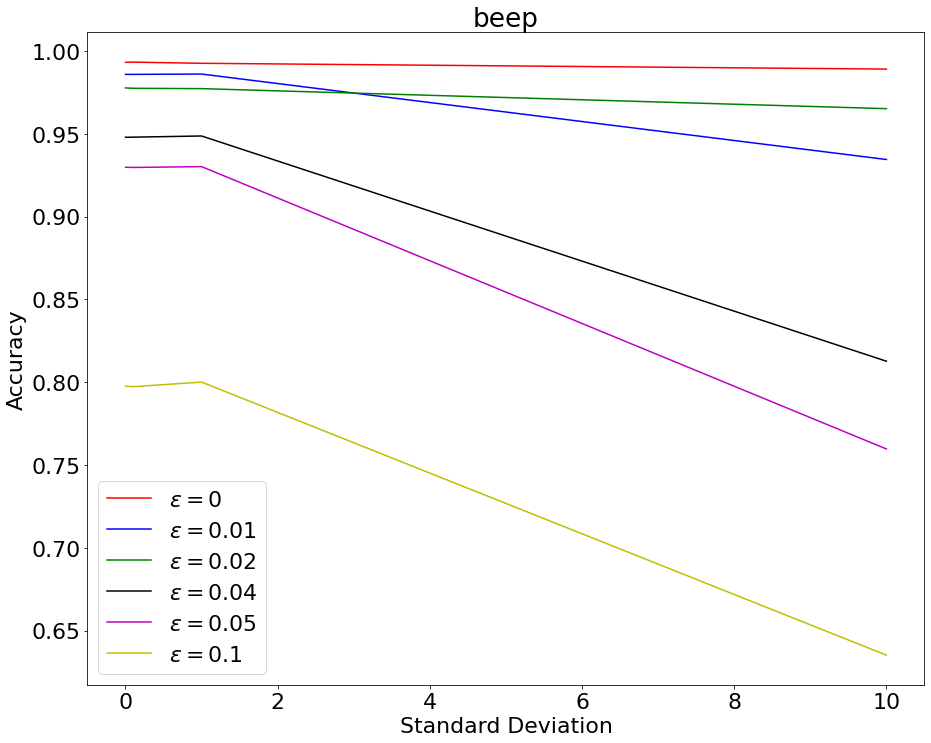

In [149]:
plot_accuracies(accuracies, 'beep')